In [1]:
import os
from pathlib import Path
from functools import partial
from typing import Any, cast

import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.model import Autoencoder
from src.datasets.mvtec_ad import MVTecAD
from src.persistence import load_model
from src.preprocessing import InferencePreprocessing

DATASET_DIR = Path(os.environ["MVTEC_DATASET_DIR"])
SAVED_MODEL = Path(os.environ["SAVED_MODEL"])
HISTORY_FILE = Path(os.environ["HISTORY_FILE"])

<Axes: xlabel='epoch'>

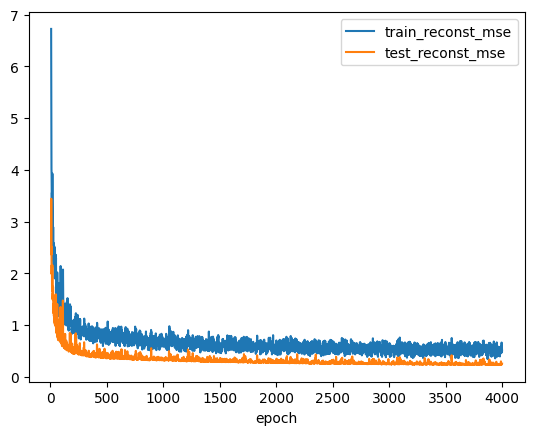

In [2]:
df_history = pd.read_csv(HISTORY_FILE)
df_history[df_history["epoch"] > 5].plot(x="epoch", y=["train_reconst_mse", "test_reconst_mse"])

In [3]:
def binary_labels(label: torch.Tensor) -> torch.Tensor:
    return torch.tensor(0) if label == 0 else torch.tensor(1)

create_ds = partial(
        MVTecAD,
        dataset_dir=DATASET_DIR,
        object=os.environ["MVTEC_OBJECT"],
        sample_transform=InferencePreprocessing(
            target_img_width=int(os.environ["IMAGE_WIDTH"]),
            target_img_height=int(os.environ["IMAGE_HEIGHT"]),
        ),
        target_transform=binary_labels,
    )
ds_train, ds_test = create_ds(training_set=True), create_ds(training_set=False)

In [4]:
model = Autoencoder()
load_model(model, SAVED_MODEL)
model.eval()

Autoencoder(
  (encoder): Encoder(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): ReLU()
  )
  (decoder): Decoder(
    (0): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

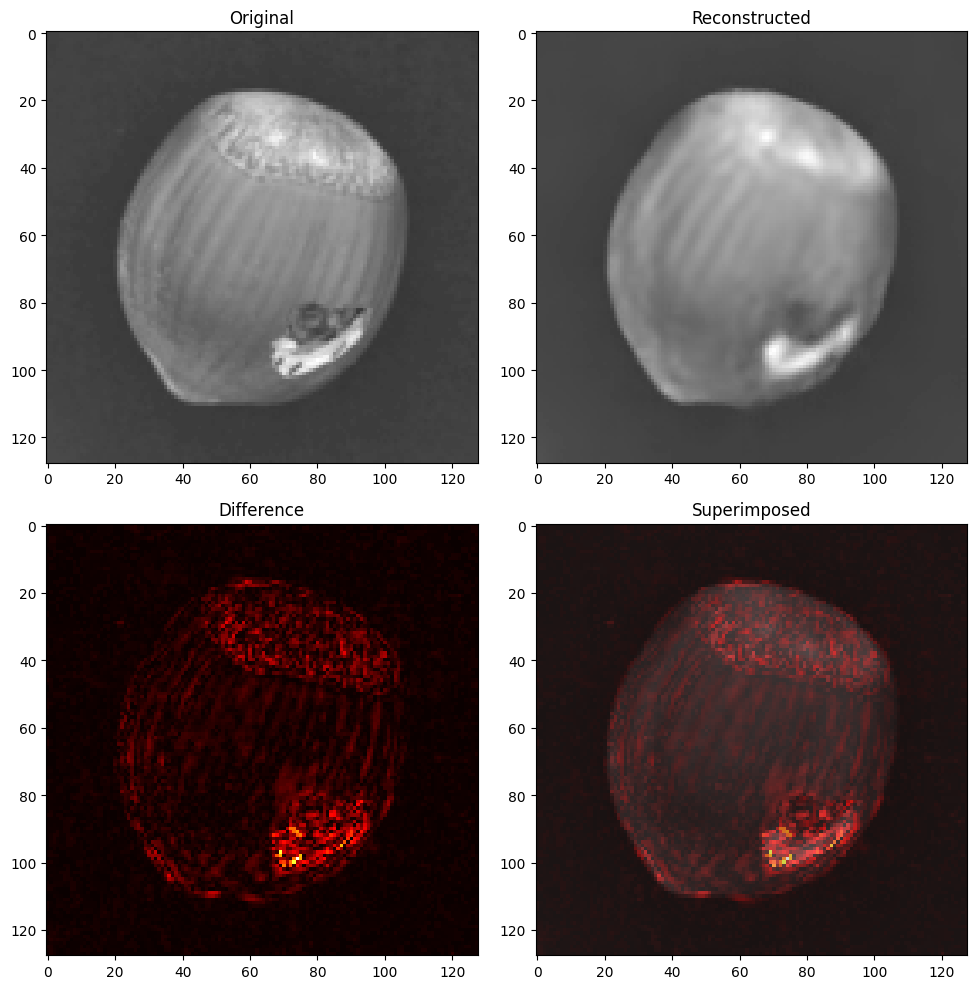

In [5]:
img_original, _ = cast(torch.Tensor, ds_test[49])
with torch.no_grad():
    img_reconstr = cast(torch.Tensor, model(img_original))

img_diff = (img_original - img_reconstr).abs()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), tight_layout=True)

def plot_image(ax, img: torch.Tensor, title: str, cmap: str, alpha=1) -> None:
    ax.imshow(img.movedim(0, -1), cmap=cmap, vmin=0, alpha=alpha)
    ax.set_title(title)

plot_image(axs[0, 0], img_original, title="Original", cmap="gray")
plot_image(axs[0, 1], img_reconstr, title="Reconstructed", cmap="gray")
plot_image(axs[1, 0], img_diff, title="Difference", cmap="hot")
plot_image(axs[1, 1], img_original, title="", cmap="grey")
plot_image(axs[1, 1], img_diff, title="Superimposed", cmap="hot", alpha=0.7)


In [6]:
data: dict[str, Any] = {"set": [], "idx": [], "loss": [], "label": []}

def perform_inference(ds: MVTecAD, set_name: str) -> None:
    loss_fn = torch.nn.L1Loss()

    for idx, (original, label) in enumerate(ds):
        with torch.no_grad():
            original = original.unsqueeze(dim=0)

            reconstructed = model(original)
            loss = loss_fn(reconstructed, original)

            data["set"].append(set_name)
            data["idx"].append(idx)
            data["loss"].append(loss.item())
            data["label"].append(int(label))

perform_inference(ds_train, "train")
perform_inference(ds_test, "test")

df = pd.DataFrame.from_dict(data)

In [7]:
print(df[["set", "loss"]].groupby("set").describe())

        loss                                                             \
       count      mean      std       min       25%       50%       75%   
set                                                                       
test   110.0  0.008049  0.00242  0.005425  0.006610  0.007223  0.008190   
train  391.0  0.006334  0.00095  0.004183  0.005645  0.006215  0.006777   

                 
            max  
set              
test   0.018369  
train  0.010787  


In [8]:
decision_boundary = df[df["set"] == "train"]["loss"].quantile(0.75)
df["prediction"] = 0
df.loc[df["loss"] > decision_boundary, "prediction"] = 1

In [9]:
df_test = df[df["set"] == "test"]

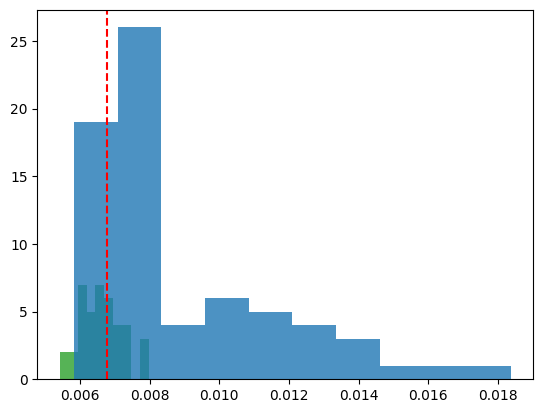

In [10]:
plt.hist(df_test[df_test["label"] == 0]["loss"], color="tab:green", alpha=0.8)
plt.hist(df_test[df_test["label"] == 1]["loss"], color="tab:blue", alpha=0.8)
plt.axvline(x=decision_boundary, color="r", linestyle="--")

In [11]:
accuracy = sum(df_test["label"] == df_test["prediction"]) / len(df_test)
accuracy

0.7636363636363637

In [12]:
df.sort_values(by="loss", ascending=False).head(10)

,set,idx,loss,label,prediction
439,test,48,0.018369,1,1
448,test,57,0.016662,1,1
443,test,52,0.015136,1,1
499,test,108,0.014223,1,1
492,test,101,0.013468,1,1
484,test,93,0.013447,1,1
447,test,56,0.013201,1,1
491,test,100,0.012857,1,1
498,test,107,0.012759,1,1
442,test,51,0.012529,1,1
